### XGBoost实战
#### 商店精确定位用户所在店铺

   这个题目的意思是，我们在商场中，由于不同层数和GPS精度限制，我们并不能仅根据经纬度准确知道某用户具体在哪一家商店中。我们通过手机与附近10个wifi点的连接情况，来精准判断出用户在哪个商店中。方便公司根据用户的位置投放相应店家的广告
   [实战链接](https://juejin.im/post/5a1bb29e51882531)

In [314]:
import xgboost
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pylab as plt

In [281]:
# 1.数据读取
train = pd.read_csv("./data/train.csv")
tests = pd.read_csv("./data/test.csv")

In [282]:
train.head()

,user_id,shop_id,time_stamp,longitude,latitude,wifi_id1,wifi_strong1,con_sta1,wifi_id2,wifi_strong2,...,con_sta7,wifi_id8,wifi_strong8,con_sta8,wifi_id9,wifi_strong9,con_sta9,wifi_id10,wifi_strong10,con_sta10
0,u_376,s_2871718,2017/8/6 21:20,122.308291,32.088040,b_6396480,-67,False,b_41124514,-86,...,FALSE,b_56326644,-89.0,FALSE,b_56328155,-77.0,FALSE,b_5857369,-55.0,false\n
1,u_376,s_2871718,2017/8/6 21:20,122.308162,32.087970,b_6396480,-67,False,b_56328155,-73,...,FALSE,b_6396479,-57.0,FALSE,b_31100514,-89.0,FALSE,b_5857369,-57.0,false\n
2,u_1041,s_181637,2017/8/2 13:10,117.365255,40.638214,b_8006367,-78,False,b_2485110,-52,...,FALSE,b_8006521,-74.0,FALSE,b_35013153,-56.0,FALSE,b_37608251,-84.0,false\n
3,u_1158,s_609470,2017/8/13 12:30,121.134451,31.197416,b_26250579,-73,False,b_26250580,-64,...,FALSE,b_30424471,-60.0,FALSE,b_26250578,-72.0,FALSE,b_29510856,-80.0,false\n
4,u_1654,s_3816766,2017/8/25 19:50,122.255867,31.351320,b_39004150,-66,False,b_39004148,-58,...,FALSE,b_6805211,-80.0,FALSE,b_1845687,-72.0,FALSE,b_21685901,-91.0,false\n


In [283]:
test.head()

,row_id,shop_id,user_id,time_stamp,longitude,latitude,wifi_id1,wifi_strong1,con_sta1,wifi_id2,...,con_sta7,wifi_id8,wifi_strong8,con_sta8,wifi_id9,wifi_strong9,con_sta9,wifi_id10,wifi_strong10,con_sta10
0,118742,NaN,u_30097142,2017-09-05 13:00:00,122.141011,39.818847,b_34366982,-82,False,b_37756289,...,FALSE,b_28978909,-62.0,FALSE,b_21518966,-68.0,FALSE,b_13748229,-72.0,false\n
1,118743,NaN,u_30097803,2017-09-06 13:10:00,118.191907,32.855858,b_36722251,-81,False,b_10537579,...,FALSE,b_21694478,-80.0,FALSE,b_44551973,-72.0,FALSE,b_21694477,-85.0,false\n
2,118744,NaN,u_30097889,2017-09-06 17:40:00,119.192110,32.424667,b_30026291,-74,False,b_30026290,...,FALSE,b_50235613,-75.0,FALSE,b_17955238,-85.0,FALSE,b_40924464,-54.0,false\n
3,118745,NaN,u_30098996,2017-09-03 12:10:00,120.612201,34.055249,b_33412374,-77,False,b_22084893,...,FALSE,b_21282193,-87.0,FALSE,b_33334040,-71.0,FALSE,b_29623262,-68.0,false\n
4,118746,NaN,u_30099170,2017-09-02 20:40:00,116.861989,40.326858,b_19882704,-77,False,b_2241462,...,FALSE,b_585687,-57.0,FALSE,b_37967785,-62.0,FALSE,b_29284311,-42.0,false\n


In [284]:
# 2.数据预处理
train.time_stamp = pd.to_datetime(pd.Series(train.time_stamp))
tests.time_stamp = pd.to_datetime(pd.Series(test.time_stamp))

In [285]:
train.time_stamp

0     2017-08-06 21:20:00
1     2017-08-06 21:20:00
2     2017-08-02 13:10:00
3     2017-08-13 12:30:00
4     2017-08-25 19:50:00
5     2017-08-28 13:10:00
6     2017-08-11 14:20:00
7     2017-08-06 14:50:00
8     2017-08-02 17:30:00
9     2017-08-02 18:30:00
10    2017-08-15 09:40:00
11    2017-08-31 18:10:00
12    2017-08-13 11:20:00
13    2017-08-13 21:30:00
14    2017-08-05 14:10:00
15    2017-08-05 14:10:00
16    2017-08-05 14:30:00
17    2017-08-05 14:30:00
18    2017-08-16 14:40:00
19    2017-08-16 14:40:00
20    2017-08-19 15:40:00
21    2017-08-13 14:10:00
22    2017-08-24 18:40:00
23    2017-08-24 20:20:00
24    2017-08-17 21:00:00
25    2017-08-03 19:20:00
26    2017-08-19 18:20:00
27    2017-08-29 11:50:00
28    2017-08-06 12:20:00
29    2017-08-27 13:30:00
              ...        
470   2017-08-16 22:00:00
471   2017-08-06 19:00:00
472   2017-08-28 19:20:00
473   2017-08-22 12:00:00
474   2017-08-28 12:10:00
475   2017-08-03 11:20:00
476   2017-08-18 21:00:00
477   2017-0

In [286]:
#　获得时间戳的有用数据
train["Year"] = train.time_stamp.apply(lambda x: x.year)
train["Month"] = train.time_stamp.apply(lambda x:x.month)
train["weekday"] = train.time_stamp.dt.dayofweek
train['time'] = train['time_stamp'].dt.time

tests['Year'] = tests['time_stamp'].apply(lambda x: x.year)
tests['Month'] = tests['time_stamp'].apply(lambda x: x.month)
tests['weekday'] = tests['time_stamp'].dt.dayofweek
tests['time'] = tests['time_stamp'].dt.time

In [287]:
# 消除冗余数据
train = train.drop("time_stamp", axis=1)
tests = tests.drop("time_stamp", axis=1)

In [288]:
train = train.dropna(axis=0)
tests = tests.fillna(method="pad")#前一个非nan值的补充方式

In [289]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467 entries, 0 to 499
Data columns (total 38 columns):
user_id          467 non-null object
shop_id          467 non-null object
longitude        467 non-null float64
latitude         467 non-null float64
wifi_id1         467 non-null object
wifi_strong1     467 non-null int64
con_sta1         467 non-null bool
wifi_id2         467 non-null object
wifi_strong2     467 non-null int64
con_sta2         467 non-null object
wifi_id3         467 non-null object
wifi_strong3     467 non-null float64
con_sta3         467 non-null object
wifi_id4         467 non-null object
wifi_strong4     467 non-null float64
con_sta4         467 non-null object
wifi_id5         467 non-null object
wifi_strong5     467 non-null float64
con_sta5         467 non-null object
wifi_id6         467 non-null object
wifi_strong6     467 non-null float64
con_sta6         467 non-null object
wifi_id7         467 non-null object
wifi_strong7     467 non-null float64
con_

In [290]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 36 columns):
row_id           500 non-null int64
shop_id          0 non-null float64
user_id          500 non-null object
time_stamp       500 non-null datetime64[ns]
longitude        500 non-null float64
latitude         500 non-null float64
wifi_id1         500 non-null object
wifi_strong1     500 non-null int64
con_sta1         500 non-null bool
wifi_id2         500 non-null object
wifi_strong2     500 non-null int64
con_sta2         500 non-null bool
wifi_id3         500 non-null object
wifi_strong3     500 non-null int64
con_sta3         500 non-null object
wifi_id4         496 non-null object
wifi_strong4     496 non-null float64
con_sta4         496 non-null object
wifi_id5         496 non-null object
wifi_strong5     496 non-null float64
con_sta5         496 non-null object
wifi_id6         486 non-null object
wifi_strong6     486 non-null float64
con_sta6         486 non-null object
wif

In [291]:
# 数据格式装换
for f in train.columns:
    if train[f].dtype == "object":
        if f != "shop_id":
#             print(f)
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
            
for f in tests.columns:
    if tests[f].dtype == "object":
        print(f)
        lbl.fit(list(tests[f].values))
        tests[f] = lbl.transform(list(tests[f].values))

user_id
wifi_id1
wifi_id2
wifi_id3
con_sta3
wifi_id4
wifi_id5
con_sta5
wifi_id6
wifi_id7
con_sta7
wifi_id8
con_sta8
wifi_id9
con_sta9
wifi_id10
con_sta10
time


In [304]:
train.head()

,user_id,shop_id,longitude,latitude,wifi_id1,wifi_strong1,con_sta1,wifi_id2,wifi_strong2,con_sta2,...,wifi_id9,wifi_strong9,con_sta9,wifi_id10,wifi_strong10,con_sta10,Year,Month,weekday,time
0,108,s_2871718,122.308291,32.088040,411,-67,False,272,-86,0,...,385,-77.0,0,402,-55.0,0,2017,8,6,73
1,108,s_2871718,122.308162,32.087970,411,-67,False,374,-73,0,...,195,-89.0,0,402,-57.0,0,2017,8,6,73
2,2,s_181637,117.365255,40.638214,434,-78,False,128,-52,0,...,232,-56.0,0,253,-84.0,0,2017,8,2,24
3,4,s_609470,121.134451,31.197416,143,-73,False,147,-64,0,...,144,-72.0,0,176,-80.0,0,2017,8,6,20
4,23,s_3816766,122.255867,31.351320,259,-66,False,250,-58,0,...,91,-72.0,0,99,-91.0,0,2017,8,4,64


In [293]:
feature_columns_to_use = ['Year', 'Month', 'weekday',
'time', 'longitude', 'latitude',
'wifi_id1', 'wifi_strong1', 'con_sta1',
 'wifi_id2', 'wifi_strong2', 'con_sta2',
'wifi_id3', 'wifi_strong3', 'con_sta3',
'wifi_id4', 'wifi_strong4', 'con_sta4',
'wifi_id5', 'wifi_strong5', 'con_sta5',
'wifi_id6', 'wifi_strong6', 'con_sta6',
'wifi_id7', 'wifi_strong7', 'con_sta7',
'wifi_id8', 'wifi_strong8', 'con_sta8',
'wifi_id9', 'wifi_strong9', 'con_sta9',
'wifi_id10', 'wifi_strong10', 'con_sta10',]


In [294]:
#数据转化为matrix类型
big_train = train[feature_columns_to_use]
big_test = tests[feature_columns_to_use]
train_X = big_train.values
train_y = train["shop_id"]
test_X = big_test.values
train_y = train['shop_id']

In [295]:
gbm = xgboost.XGBClassifier(slice=1, max_depth=10, n_estimators=1000, learning_rate=0.05)
gbm.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, slice=1, subsample=1, verbosity=1)

In [296]:
predictions = gbm.predict(test_X)

In [297]:
predictions

array(['s_330608', 's_552320', 's_3356003', 's_591653', 's_293805',
       's_10859', 's_461573', 's_411850', 's_70790', 's_3795241',
       's_293082', 's_449515', 's_1334527', 's_411850', 's_80293',
       's_386448', 's_298312', 's_541078', 's_296179', 's_298488',
       's_3686420', 's_299856', 's_3816766', 's_9899', 's_3210888',
       's_52283', 's_330608', 's_384764', 's_3210888', 's_330608',
       's_3743209', 's_3816766', 's_3743209', 's_3210888', 's_440043',
       's_824128', 's_382453', 's_43998', 's_10859', 's_2956027',
       's_293082', 's_43998', 's_54272', 's_293805', 's_3648442',
       's_383937', 's_2796281', 's_293082', 's_391549', 's_299856',
       's_298488', 's_410754', 's_779170', 's_324213', 's_3773709',
       's_3210888', 's_428339', 's_299856', 's_403766', 's_410754',
       's_1135668', 's_410754', 's_541078', 's_782565', 's_3698335',
       's_405224', 's_411043', 's_428339', 's_1191698', 's_363090',
       's_412164', 's_3494433', 's_250851', 's_411850

In [306]:
test.head()

,row_id,shop_id,user_id,time_stamp,longitude,latitude,wifi_id1,wifi_strong1,con_sta1,wifi_id2,...,con_sta7,wifi_id8,wifi_strong8,con_sta8,wifi_id9,wifi_strong9,con_sta9,wifi_id10,wifi_strong10,con_sta10
0,118742,NaN,u_30097142,2017-09-05 13:00:00,122.141011,39.818847,b_34366982,-82,False,b_37756289,...,FALSE,b_28978909,-62.0,FALSE,b_21518966,-68.0,FALSE,b_13748229,-72.0,false\n
1,118743,NaN,u_30097803,2017-09-06 13:10:00,118.191907,32.855858,b_36722251,-81,False,b_10537579,...,FALSE,b_21694478,-80.0,FALSE,b_44551973,-72.0,FALSE,b_21694477,-85.0,false\n
2,118744,NaN,u_30097889,2017-09-06 17:40:00,119.192110,32.424667,b_30026291,-74,False,b_30026290,...,FALSE,b_50235613,-75.0,FALSE,b_17955238,-85.0,FALSE,b_40924464,-54.0,false\n
3,118745,NaN,u_30098996,2017-09-03 12:10:00,120.612201,34.055249,b_33412374,-77,False,b_22084893,...,FALSE,b_21282193,-87.0,FALSE,b_33334040,-71.0,FALSE,b_29623262,-68.0,false\n
4,118746,NaN,u_30099170,2017-09-02 20:40:00,116.861989,40.326858,b_19882704,-77,False,b_2241462,...,FALSE,b_585687,-57.0,FALSE,b_37967785,-62.0,FALSE,b_29284311,-42.0,false\n


In [309]:
submission = pd.DataFrame({"row_id":tests.row_id,
                          "shop_id":predictions})
submission.to_csv("预测结果")

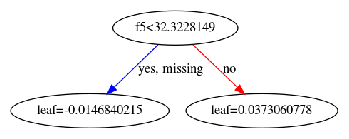

In [318]:
xgboost.plot_tree(gbm, num_trees=4)